# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob
import pickle

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [2]:
#import custom functions
from custom_functions import *

## Download data

In [3]:
#load raws into dataframe
#Choose band to generate canny edge from, select None to skip edge generation
target_edge = 'B8A'
sigma = 3
sim_raws = gdal_to_dataframe('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif', calculate_edge = target_edge, sigma = sigma)
lab_raws = gdal_to_dataframe('../data_tests/labrador/raws', sigma = sigma)
james_raws = gdal_to_dataframe('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif', calculate_edge = target_edge, sigma = sigma)
tor_raws = gdal_to_dataframe('../data_tests/toronto/raws', calculate_edge = target_edge, sigma = sigma)
sjames_raws = gdal_to_dataframe('../data_tests/james_south/raws', calculate_edge = target_edge, sigma = sigma)
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws', calculate_edge = target_edge, sigma = sigma)
trois_raws = gdal_to_dataframe('../data_tests/trois/raws', calculate_edge = target_edge, sigma = sigma)
winn_raws = gdal_to_dataframe('../data_tests/winnipeg/raws', calculate_edge = target_edge, sigma = sigma)
sask_raws = gdal_to_dataframe('../data_tests/sasketchewan/raws', calculate_edge = target_edge, sigma = sigma)
newf_raws = gdal_to_dataframe('../data_tests/newfoundland/raws', calculate_edge = target_edge, sigma = sigma)

getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge


# EDA & Feature Selection

In [ ]:
#plot band
map_band = np.asarray(newf_raws['B12'].values).reshape(1635, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

In [ ]:
#comparing example band distribution within each class across two extents
plt.scatter(lab_raws['B01'], lab_raws.y)
plt.scatter(sim_raws['B01'], sim_raws.y)

## Geocoordinates

In [ ]:
#OPTIONAL: get geocoordinates
sim_raws['lat'], sim_raws['long'] = get_geocoord('../data_tests/simcoe_york/raws')
lab_raws['lat'], lab_raws['long'] = get_geocoord('../data_tests/labrador/raws')
tor_raws['lat'], tor_raws['long'] = get_geocoord('../data_tests/toronto/raws')
james_raws['lat'], james_raws['long'] = get_geocoord('../data_tests/james_bay/raws')
sjames_raws['lat'], sjames_raws['long'] = get_geocoord('../data_tests/james_south/raws')
cal_raws['lat'], cal_raws['long'] = get_geocoord('../data_tests/calgary/raws')
trois_raws['lat'], trois_raws['long'] = get_geocoord('../data_tests/trois/raws')
winn_raws['lat'], winn_raws['long'] = get_geocoord('../data_tests/winnipeg/raws')
sask_raws['lat'], sask_raws['long'] = get_geocoord('../data_tests/sasketchewan/raws')
newf_raws['lat'], newf_raws['long'] = get_geocoord('../data_tests/newfoundland/raws')

In [ ]:
sask_raws['lat'][0], sask_raws['long'][0]

### K-means clustering

In [ ]:
#visualize effect with test raws
test_raws = pd.concat([sim_raws, tor_raws, lab_raws, cal_raws, trois_raws, james_raws, sjames_raws])
test_raws = test_raws.drop('y', axis = 1)

cl = cluster.KMeans(n_clusters=6, random_state = 0) # create an object of the classifier
param = cl.fit(test_raws) # train it
img_cl = cl.labels_ 

#select first image for visualization
img_sim = img_cl[:2500 * 2134].reshape(2134, 2500)

In [ ]:
#visualize clustering using split images
plt.figure(figsize=[20,20])
plt.imshow(img_sim, cmap=cmap)
plt.axis('off')

### Outlier fixing

In [ ]:
#OPTIONAL: run to transform outliers on all raws

james_raws = outlier_fix(james_raws)
tor_raws = outlier_fix(tor_raws)
sim_raws = outlier_fix(sim_raws)
lab_raws = outlier_fix(lab_raws)
sjames_raws =  outlier_fix(sjames_raws)
trois_raws = outlier_fix(trois_raws)
cal_raws = outlier_fix(cal_raws)
winn_raws = outlier_fix(winn_raws)

In [ ]:
def add_fix_column(raws, target):
    raws[target] = outlier_fix(raws)[target]
    return raws

In [4]:
#OPTIONAL: run to add single column based on an outlier fix of another
target = 'B01f'

james_raws = add_fix_column(james_raws, target)
tor_raws= add_fix_column(tor_raws, target)
sim_raws = add_fix_column(sim_raws, target)
lab_raws = add_fix_column(lab_raws, target)
sjames_raws =  add_fix_column(sjames_raws, target)
trois_raws = add_fix_column(trois_raws, target)
cal_raws = add_fix_column(cal_raws, target)
winn_raws = add_fix_column(winn_raws, target)
sask_raws = add_fix_column(sask_raws, target)
newf_raws = add_fix_column(newf_raws, target)

In [ ]:
#Double check outlier fix
plt.scatter(james_raws['B01f'], james_raws['B02f'])

### Gaussian filtering

In [ ]:
#load gaussian filtered raws
sim_gauss = filter_raws('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_gauss = filter_raws('../data_tests/labrador/raws')
james_gauss = filter_raws('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif')
tor_gauss = filter_raws('../data_tests/toronto/raws')
sjames_gauss = filter_raws('../data_tests/james_south/raws')
cal_gauss = filter_raws('../data_tests/calgary/raws')
trois_gauss = filter_raws('../data_tests/trois/raws')
winn_gauss = filter_raws('../data_tests/winnipeg/raws')

In [ ]:
#put together raw and filtered df of each scene
#create list of input images
train_raw = [tor_raws, sim_raws, lab_raws, cal_raws, james_raws, sjames_raws, trois_raws, winn_raws]
train_gauss = [tor_gauss, sim_gauss, lab_gauss, cal_raws, james_gauss, sjames_gauss, trois_gauss, winn_gauss]

#set empty main
main_dataframe = pd.DataFrame()

for i in range(len(train_raw)):
    #drop y from gauss
    temp_gauss = train_gauss[i].drop('y', axis = 1)
    #rename gauss columns
    gauss_names = [f'{name}g' for name in temp_gauss.columns]
    temp_gauss.columns = gauss_names
    #print(temp_gauss.head(), train_raw[i].head())
    
    #reset indices
    train_raw[i].reset_index(inplace=True, drop=True)
    temp_gauss.reset_index(inplace=True, drop=True)       
    new_df = pd.concat([train_raw[i], temp_gauss], axis = 1)
    #add to main
    main_dataframe = pd.concat([main_dataframe, new_df])

main_dataframe = main_dataframe.iloc[:,:-4]
    
print(new_df.shape, lab_raws.shape)
main_dataframe.head()

### Combine extents

In [5]:
#NOTE: skip if filtered extents have been run
#vertical concat
main_dataframe = pd.concat([sim_raws, lab_raws, tor_raws, james_raws, sjames_raws, cal_raws, trois_raws, sask_raws, newf_raws])
main_dataframe = main_dataframe.reset_index().drop('index', axis = 1)
#main_dataframe = replace_values(main_dataframe)                
#main_dataframe = pd.concat([tor_gauss, james_gauss, sim_gauss, lab_gauss])

In [ ]:
#OPTIONAL: run to add cluster column
cl = cluster.KMeans(n_clusters = 4)
dataframe_copy = main_dataframe.drop('y', axis = 1)
param = cl.fit(dataframe_copy.astype('double'))
img_cl = cl.labels_
    
main_dataframe['clusters'] = img_cl    

In [ ]:
#pickle cluster model
pickle.dump(param, open('models/kcluster_13.sav', 'wb'))

In [ ]:
#Visulization of band distribution for each class in the main dataframe

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = main_dataframe[main_dataframe.columns[:-1][i]]
    Y_scatter = main_dataframe['y']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(main_dataframe.columns[i])

# Processing Data

### Calculated Layers

In [6]:
#OPTIONAL: run to calculate layers
main_dataframe = add_layers(main_dataframe)
#main_dataframe = add_extra_layers(main_dataframe) #add additional layers, uncomment to add
main_dataframe = replace_values(main_dataframe)

#only keep filtered bands
#main_dataframe = main_dataframe.iloc[:, 12:]

In [ ]:
#preview calculated layers using example raw
test_plus = add_layers(trois_raws)
test_plus = replace_values(test_plus)

#preview calculated layers
map_band = np.asarray(test_plus['NDVI'].values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

### Subsampling

In [7]:
#check features
main_dataframe.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'edge', 'y', 'B01f', 'NDVI', 'Moisture', 'NDWI', 'NDSI'],
      dtype='object')

In [8]:
#check dataframe shape and print class value counts
print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(16708750, 19)
y 
0      181478
1     2565416
2      309162
5     1681472
6     1105593
8     1508489
10     323304
11     165824
12     673799
13     631839
14     448283
15    3454935
16     652362
17     749435
18    2207866
19      49493
dtype: int64


In [ ]:
#OPTIONAL: run to create a binary model by converting train and test to binary based on input class
main_dataframe = convert_binary(main_dataframe, 14)

In [9]:
#final clean
#drop 0
main_dataframe = main_dataframe.loc[main_dataframe.y != 0]

#select classes above threshold
threshold = 150000
top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)

#add on snow - uncomment if threshold > class total
snow_subset = main_dataframe.loc[main_dataframe.y == 19]
data = pd.concat([data, snow_subset])
polar_shrub_subset = main_dataframe.loc[main_dataframe.y == 11]
#data = pd.concat([data, polar_shrub_subset])


print(data.shape)
data.value_counts('y').sort_index()

(2149493, 19)


y 
1     150000
2     150000
5     150000
6     150000
8     150000
10    150000
11    150000
12    150000
13    150000
14    150000
15    150000
16    150000
17    150000
18    150000
19     49493
dtype: int64

In [ ]:
#OPTIONAL: save current data to csv
data.to_csv('../data_tests/version15.csv', index = False)

## Train test split

In [10]:
y = data.y
X = data.drop('y', axis = 1)

#Dimensionality reduction - replace X with X_pca and run to try
pca = PCA(n_components = 1)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.99406705]


In [ ]:
#OPTIONAL: run to scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# Modelling

In [ ]:
#set up save path for images
confusion_path = 'evaluation/'
group_folder = None

## Random Forest

0.6289895998827632


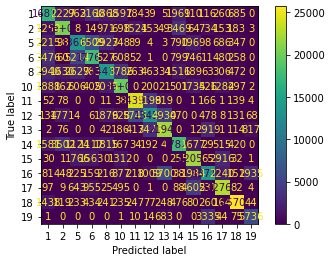

In [11]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 300, max_depth = 15, max_features = 2).fit(X_train, y_train)
#get accuracy
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))

#plot confusion matrix
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [12]:
#make sure there's no overfit
forest_train_pred = forest.predict(X_train)
print(accuracy_score(y_train, forest_train_pred))

0.6518974827779115


In [ ]:
print_importance(forest, X_train)

In [ ]:
#OPTIONAL: save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'forest.png'))
print(classification_report(y_test, forest_pred))

In [ ]:
#OPTIONAL: save model
pickle.dump(forest, open('../models/forest_16.sav', 'wb'))

### Demo test

In [ ]:
#combining all options for custom preprocess function
def process_data(path_csv, path_raws, nrcan_name = 'land_cover.tif', index = [0, 3], target_edge = False, edge_sigma = 3, geocoords = False,
                 target_outlier = False, gaussian = False, clustering = False, calculate_layers = False):
    """
    Master function that combines all above processing functions and applies to raws from input path to raw directory. 
    Features are generated based on inputted parameters and added as columns to outputted frame
    By default function function is equivalent to gdal_to_dataframe but with different default parameters
    
    INPUT
    ------
    `path_csv`: In the case of certain extents the NRCAN land cover tif was corrupted while a csv of correct land cover
    values remained. 
    If this is not the case, set path_csv to None and function will proceed with land cover from gdal_to_dataframe
    `path_raws`: string with path to the raw files directory
    `nrcan_name`: file name of the accompanying nrcan classification extent. File must be in directory above raw directory
    `index`: Index within raw band file names where the band name is found. 
    `target_edge`: If set equal to band name (ex: 'B01') will return canny edge (sigma 3) of that band under column labeled
    'edge'
    `geocoords`: If set to True will return lat and long geocoordinates
    `target_outlier`:  If set equal to band name (ex: 'B01') will return column of values where outliers have been
    transformed using `outlier_fix`
    Outlier fixed columns can be recognized with an appended `f` (ex: 'B01f`)
    `gaussian`: If set to true implements `raw_filters` and returns transformed columns to add on to original raw columns.
    Filtered columns can be recognized with an appended `g` (ex: 'B01g`)
    `clustering`: If set to string of path to a k-means clustering (.sav) model, performs k means clustering on raws and 
    returns column labeled 'cluster'
    `calculate_layers`: If set to True calculates 4 additional layers from raw values: NDVI, NDWI, Moisture and NDSI.
    If set to 'Extra' calculates 4 previous layers plus an additional 5 layers: NIRB, ARG, yellow, MIVI, GDVI
    
    
    OUTPUT
    ------
    X_demo, y_demo: Two pd DataFrames()
    \-> X_demo: contains all features generated by function based on input parameters
    \-> y_demo: contains associated labels of land cover classes
    """
    
    
    if path_csv is not None:
        #get y from csv and reshape
        raw = pd.read_csv(path_csv)
        raw.land_cover = raw.land_cover.astype('int')
        y_demo = raw['land_cover']
        #reshape to use y_demo with gaussian X
        y_demo = y_demo.values.reshape(2500, 2100).T
        y_demo = y_demo.flatten()
        
         #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index, calculate_edge = target_edge, sigma = edge_sigma)
        X_demo = raw.drop('y', axis = 1)
    else:
        #get X from gdal function
        raw = gdal_to_dataframe(path_raws, nrcan_name = nrcan_name, index = index, calculate_edge = target_edge, sigma = edge_sigma)
        y_demo = raw.y
        X_demo = raw.drop('y', axis = 1)
    
    if geocoords is True:
        X_demo['lat'], X_demo['long'] = get_geocoord(path_raws)
    

    if target_outlier is not False:
        if target_outlier[0] == 'B':
            X_demo[target_outlier] = outlier_fix(X_demo)[target_outlier]
        else:
            X_demo = outlier_fix(X_demo)
    
    if gaussian == True:
        #filter raws from path
        gauss_demo = filter_raws(path_raws, nrcan_name = nrcan_name, index = index)

        #concat gauss and raw
        gauss_demo_reset = gauss_demo.drop('y', axis = 1)
        #rename gauss columns
        gauss_names_reset = [f'{name}g' for name in gauss_demo_reset.columns]
        gauss_demo_reset.columns = gauss_names_reset
        #reset indices
        raw.reset_index(inplace=True, drop=True)
        gauss_demo_reset.reset_index(inplace=True, drop=True)    
        merged_df = pd.concat([X_demo, gauss_demo_reset], axis = 1)

        #select X values from gaussian dataframe
        X_demo = merged_df

    if clustering is not False:
        param = pickle.load(open(clustering, 'rb'))
        demo_cluster = param.predict(X_demo.astype('double'))
        X_demo['clusters'] = demo_cluster
        
    if calculate_layers is not False:
        X_demo = add_layers(X_demo)
        X_demo = replace_values(X_demo)
        
        if calculate_layers == 'Extra':
            X_demo = add_extra_layers(X_demo)
        
    return X_demo, y_demo

In [ ]:
X_train.columns

In [13]:
X_demo, y_demo = process_data('../data_tests/demo_site.csv', '../data_tests/demo/raws', target_edge = 'B8A',
                 geocoords = False, target_outlier = 'B01f', edge_sigma = 3, gaussian = False, clustering = False, calculate_layers = True) 

getting edge


In [ ]:
target_class = 14
y_demo = np.where(y_demo != target_class, 0, y_demo)
y_demo = np.where(y_demo == target_class, 1, y_demo)

In [ ]:
#make sure we have the right features
X_demo.columns

In [ ]:
#OPTIONAL: load specific model
forest = pickle.load(open('models/forest_10.sav', 'rb'))

In [14]:
#generate predictions
demo_pred = forest.predict(X_demo)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.31613271309512087
0.3563607619047619


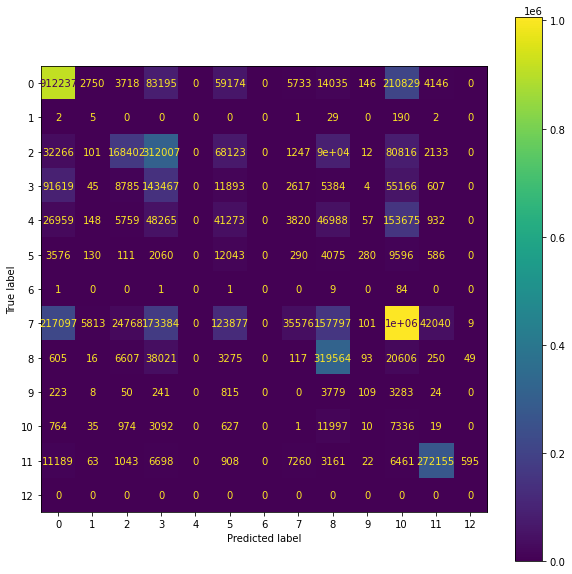

In [15]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
print(classification_report(y_demo, demo_pred, zero_division = 0))


In [ ]:
demo_pred = (forest.predict_proba(X_demo)[:,1] >= 0.6).astype(bool)

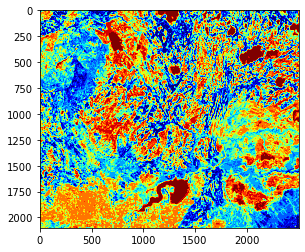

In [17]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap =demo_cmap)

In [ ]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'demo/RFC', 'version_16.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join(confusion_path, 'demo/RFC', 'map_16.png'))

In [ ]:
#create a copy to check the distribution of specific class predicitons
check_class_pred = deepcopy(demo_pred.values)

check_class_pred = np.where(check_class_pred != 14, 0, check_class_pred)
check_class_pred = np.where(check_class_pred == 14, 1, check_class_pred)

In [ ]:
#plot feature or specific class
map_feat = np.asarray(y_demo).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 2)    # set discrete

feature_map = plt.imshow(map_feat, cmap = cmap)

### Random extent test

In [ ]:
y_ran = trois_raws.y
X_ran = trois_raws.drop('y', axis = 1)

In [ ]:
#OPTIONAL: run to get gaussian version of toronto
gauss_test = filter_raws('../data_tests/trois/raws')
gauss_test.head()

gauss_test['y'] = gauss_test['y'].replace({0:18})

#replace X and y with gauss
#concat gauss and raw
gauss_test_reset = gauss_test.drop('y', axis = 1)
#rename gauss columns
gauss_names = [f'{name}g' for name in gauss_test_reset.columns]
gauss_test_reset.columns = gauss_names
#reset indices
trois_raws.reset_index(inplace=True, drop=True)
gauss_test_reset.reset_index(inplace=True, drop=True)    
merged_df = pd.concat([trois_raws, gauss_test_reset], axis = 1)

In [ ]:
y_ran = merged_df.y
X_ran = merged_df.drop('y', axis = 1)

In [ ]:
ran_cluster = param.predict(X_ran.astype('double'))
X_ran['clusters'] = ran_cluster

In [ ]:
#OPTIONAL: add calculated layers
X_ran = add_layers(X_ran)
X_ran = replace_values(X_ran)

In [ ]:
X_ran['B12f'] = outlier_fix(X_ran)['B12f']

In [ ]:
#optional PCA, to use replace X_tor in predict with X_tor_pca
pca = PCA(n_components = 6)
X_ran_pca = pca.fit_transform(X_ran)

#predict
ran_pred = forest.predict(X_ran)
print(balanced_accuracy_score(y_ran, ran_pred))

#display
cm_forest = confusion_matrix(y_ran, ran_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
#display prediction map
map_pred = np.asarray(ran_pred).reshape(656, 1250)
cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

#save
#prediction_map.figure.savefig(os.path.join(confusion_path, 'gaussian', 'map_tor.png'))

In [ ]:
#display prediction map
map_pred = np.asarray(y_ran).reshape(656, 1250)
cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

## SVC

In [ ]:
#NOTE: takes a long time to run

In [ ]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [ ]:
#predict from X_test
#linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
#rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
#accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
#accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
#cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
#cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
#cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
#cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
#print(accuracy_lin)
#cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
#print(accuracy_rbf)
#cm_rbf_fig.plot()

In [ ]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)

## XGBoost

In [ ]:
#UNDER CONSTRUCTION: Predictions are lower than they should be

In [ ]:
xg_classes

In [ ]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

In [ ]:
y_train = y_train.astype('object')

In [ ]:
y_train

In [ ]:
xgb.__version__

In [ ]:
X_train['edge'] = X_train['edge'].astype('int')
X_test['edge'] = X_test['edge'].astype('int')

In [ ]:
xg_cl = xgb.XGBClassifier().fit(X_train, y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [ ]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)

In [ ]:
X_demo['edge'] = X_test['edge'].astype('int')

#generate predictions
demo_pred = xg_cl.predict_proba(X_demo)

In [ ]:
demo_pred = xg_cl.predict(X_demo)

In [ ]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
demo_pred = (xg_cl.predict_proba(X_demo)[:,1] >= 0.60).astype(bool)

In [ ]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
RocCurveDisplay.from_predictions(y_demo, demo_pred)

In [ ]:
pickle.dump(forest, open('../models/xgb_bin14_v2.sav', 'wb'))

In [ ]:
#plot demo prediction map
map_pred = np.asarray(y_demo).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [ ]:
X_demo['edge'].astype(int)

In [ ]:
#--Don't use for now, come back to it for when its time to submit--
#convert into matrices to perform gaussian then convert back into 1d array and append to dataframe
X_demo_gauss = pd.DataFrame()
for band in X_demo.columns:
    band = X_demo.columns[1]
    reconstruct = np.asarray(X_demo[band]).reshape(2500, 2100).T
    recon_gauss = gaussian_filter(reconstruct, sigma = 1)
    X_demo_gauss[band] = recon_gauss.flatten()
    
#compare demo input and gauss output
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(reconstruct)
ax2.imshow(recon_gauss)